In [7]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import graphviz as gr
plt.style.use("fivethirtyeight")

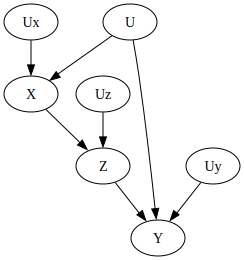

In [9]:
g = gr.Digraph()

g.edge("U", "X")
g.edge("X", "Z")
g.edge("Z", "Y")
g.edge("U", "Y")
g.edge("Ux", "X")
g.edge("Uy", "Y")
g.edge("Uz", "Z")

g

In [10]:
class GPSMemorySCM:
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_x = stats.truncnorm(0, np.infty, scale=5)
        self.u_y = stats.norm(scale=2)
        self.u_z = stats.norm(scale=2)
        self.u = stats.truncnorm(0, np.infty, scale=4)
    
    def sample(self, sample_size=100, treatment_value=None):
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_x = self.u_x.rvs(sample_size)
        u_y = self.u_y.rvs(sample_size)
        u_z = self.u_z.rvs(sample_size)
        u = self.u.rvs(sample_size)

        if treatment_value:
            gps = np.array([treatment_value] *sample_size)
        else:
            gps = u_x + 0.7 * u
        
        hippocampus = -0.6 * gps + .25 * u_z
        memory = 0.7 * hippocampus + 0.25 * u
        return gps, hippocampus, memory

    def intervene(self, treatment_value, sample_size=100):
        return self.sample(treatment_value=treatment_value, sample_size=sample_size)        



In [25]:
scm = GPSMemorySCM()

# Generate observational data
gps_obs, hippocampus_obs, memory_obs = scm.sample(600)

# Run an experience
treatments = []
experiment_results = []
# Sample over a range of treatments
for treatment in np.arange(1, 21):
    #print(treatment)
    gps_hours, hippocampus, memory = scm.intervene(treatment_value=treatment, sample_size=30)
    #print(gps_hours)
    experiment_results.append(memory)
    treatments.append(gps_hours)

Text(0.5, 0, 'GPS Usage')

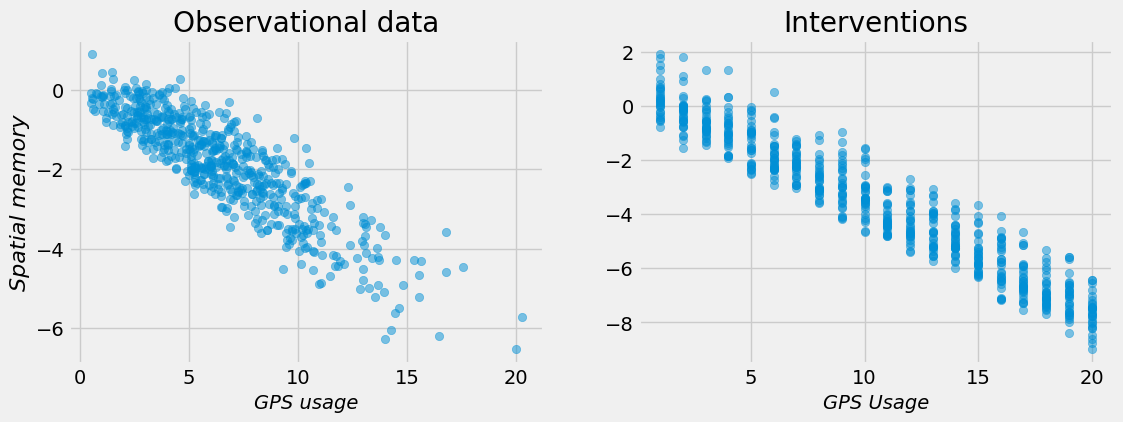

In [39]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(gps_obs, memory_obs, alpha=.5)
plt.title("Observational data")
plt.xlabel("GPS usage", fontsize=14, style="italic")
plt.ylabel("Spatial memory", fontsize=16, style="italic")

plt.subplot(122)
plt.scatter(treatments, experiment_results, alpha=.5)
plt.title("Interventions")
plt.xlabel("GPS Usage", fontsize=14, style="italic")

In [41]:
lr_naive = LinearRegression()
lr_naive.fit(
    X = gps_obs.reshape(-1, 1),
    y = memory_obs
)


LinearRegression()

In [42]:
treatments_unpack = np.array(treatments).flatten()
results_unpack = np.array(experiment_results).flatten()
lr_experiment = LinearRegression()
lr_experiment.fit(
    X=treatments_unpack.reshape(-1, 1),
    y=results_unpack
)

LinearRegression()

In [43]:
X_test = np.arange(1, 21).reshape(-1, 1)
preds_naive = lr_naive.predict(X_test)
preds_experiment =  lr_experiment.predict(X_test)

In [44]:
print(f"Naive model: {lr_naive.coef_}")
print(f"Experimental model: {lr_experiment.coef_}")

Naive model: [-0.33075364]
Experimental model: [-0.41289083]


## How to get a vavid causal coefficient using front-door
- Fit $Z \backsim X$
- Fit $Y \backsim Z + X$
- Multiply the coefficients from the model 1 and model 2

In [45]:
lr_zx = LinearRegression()
lr_zx.fit(
    X=gps_obs.reshape(-1, 1),
    y = hippocampus_obs
)

lr_yxz = LinearRegression()
lr_yxz.fit(
    X=np.array([gps_obs, hippocampus_obs]).T,
    y=memory_obs
)

lr_zx.coef_[0] * lr_yxz.coef_[1]

-0.43808656890443076